Using device: cuda


<ipython-input-1-e07d2ca1d7fe>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor_data = torch.load(tensor_data_path)  # Shape: (num_frames, num_classes)
<ipython-inpu

Epoch [1/2000], Loss: 2.4508, Accuracy: 28.85%
Epoch [2/2000], Loss: 1.5853, Accuracy: 53.15%
Epoch [3/2000], Loss: 1.1029, Accuracy: 66.43%
Epoch [4/2000], Loss: 0.9525, Accuracy: 69.37%
Epoch [5/2000], Loss: 0.8819, Accuracy: 70.34%
Epoch [6/2000], Loss: 0.8415, Accuracy: 70.59%
Epoch [7/2000], Loss: 0.8145, Accuracy: 71.09%
Epoch [8/2000], Loss: 0.7930, Accuracy: 71.41%
Epoch [9/2000], Loss: 0.7799, Accuracy: 71.40%
Epoch [10/2000], Loss: 0.7644, Accuracy: 71.90%
Epoch [11/2000], Loss: 0.7556, Accuracy: 71.92%
Epoch [12/2000], Loss: 0.7462, Accuracy: 72.26%
Epoch [13/2000], Loss: 0.7395, Accuracy: 72.28%
Epoch [14/2000], Loss: 0.7308, Accuracy: 72.72%
Epoch [15/2000], Loss: 0.7257, Accuracy: 72.56%
Epoch [16/2000], Loss: 0.7192, Accuracy: 72.97%
Epoch [17/2000], Loss: 0.7146, Accuracy: 73.06%
Epoch [18/2000], Loss: 0.7090, Accuracy: 73.39%
Epoch [19/2000], Loss: 0.7042, Accuracy: 73.40%
Epoch [20/2000], Loss: 0.7025, Accuracy: 73.29%
Epoch [21/2000], Loss: 0.6983, Accuracy: 73.81%
E

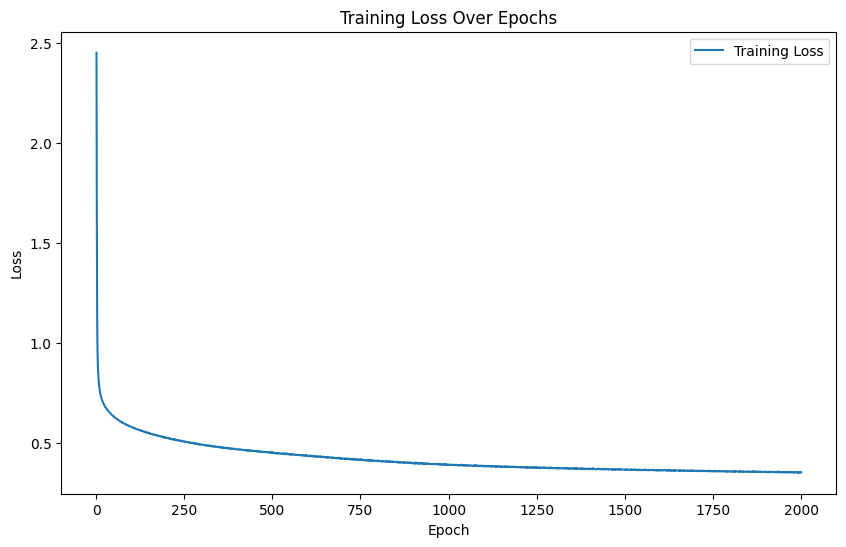

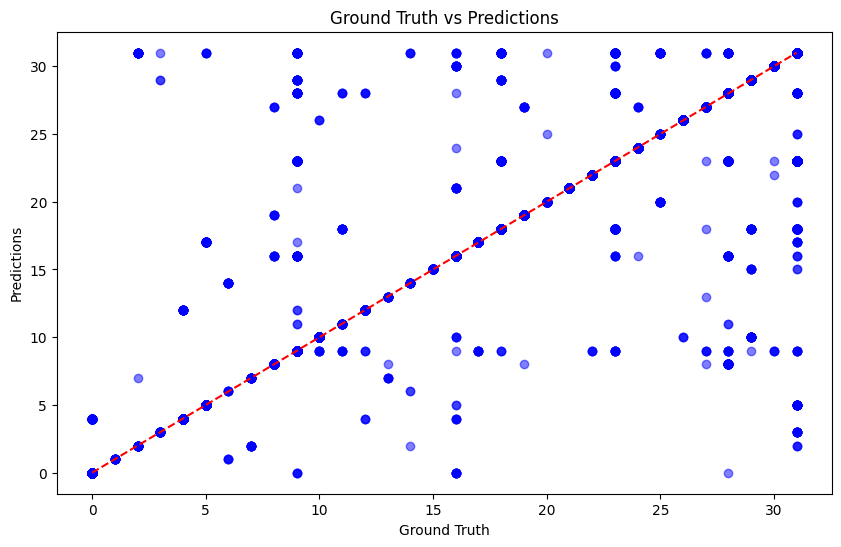

In [ ]:
import torch
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


tensor_data_path = "/content/run1b_2018-05-29-14-02-47.kinect_color.pt"
tensor_data = torch.load(tensor_data_path)  # Shape: (num_frames, num_classes)

if isinstance(tensor_data, list):
    tensor_data = torch.tensor(tensor_data, dtype=torch.float32)

annotations_path = "/content/training_data.csv"
annotations_df = pd.read_csv(annotations_path)

annotations_df = annotations_df.replace('NA', 0)


annotations = annotations_df.iloc[:, -1].values

if np.issubdtype(annotations.dtype, np.number):
    annotations_numeric = annotations
else:
    label_encoder = LabelEncoder()
    annotations_numeric = label_encoder.fit_transform(annotations)

scaler = MinMaxScaler()
tensor_data_scaled = scaler.fit_transform(tensor_data.numpy())  # Normalize tensor data to [0, 1]


tensor_data_scaled = torch.tensor(tensor_data_scaled, dtype=torch.float32)

class TemporalActivityDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

dataset = TemporalActivityDataset(tensor_data_scaled, annotations_numeric)
data_loader = DataLoader(dataset, batch_size=64, shuffle=True)

class TemporalActivityModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(TemporalActivityModel, self).__init__()
        self.lstm = torch.nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)

        if lstm_out.ndimension() == 2:
            lstm_out = lstm_out.unsqueeze(1)

        out = self.fc(lstm_out[:, -1, :])  # Last time step output
        return out



input_dim = tensor_data_scaled.shape[1]  # Features per frame
hidden_dim = 64
output_dim = len(np.unique(annotations_numeric))  # Number of classes (activities)
model = TemporalActivityModel(input_dim, hidden_dim, output_dim)

criterion = torch.nn.CrossEntropyLoss()  # CrossEntropyLoss for classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 2000
train_losses = []

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for inputs, labels in data_loader:
        # Cast inputs and labels to float32 to avoid dtype mismatch
        inputs = inputs.float()
        labels = labels.long()

        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Forward pass

        loss = criterion(outputs, labels)  # Loss calculation
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize parameters

        running_loss += loss.item()


        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

    avg_loss = running_loss / len(data_loader)
    accuracy = (correct_predictions / total_predictions) * 100
    train_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

model.eval()
predictions = []
ground_truth = []

with torch.no_grad():
    for inputs, labels in data_loader:
        inputs = inputs.float()  # Ensure inputs are in float32
        labels = labels.long()  # Ensure labels are in long integers
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)  # Get the predicted class
        predictions.append(predicted.numpy())
        ground_truth.append(labels.numpy())

predictions = np.concatenate(predictions)
ground_truth = np.concatenate(ground_truth)

accuracy = np.mean(predictions == ground_truth) * 100
print(f"Test Accuracy: {accuracy:.2f}%")

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(ground_truth, predictions, color='blue', alpha=0.5)
plt.plot([min(ground_truth), max(ground_truth)], [min(ground_truth), max(ground_truth)], color='red', linestyle='--')
plt.xlabel('Ground Truth')
plt.ylabel('Predictions')
plt.title('Ground Truth vs Predictions')
plt.show()


<ipython-input-1-d0564fd079d1>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor_data = torch.load(tensor_data_path)  # Shape: (num_frames, num_classes)
<ipython-inpu

Epoch [1/3000], Loss: 2.4862, Accuracy: 27.59%
Epoch [2/3000], Loss: 1.7019, Accuracy: 49.43%
Epoch [3/3000], Loss: 1.1713, Accuracy: 65.44%
Epoch [4/3000], Loss: 0.9865, Accuracy: 68.62%
Epoch [5/3000], Loss: 0.9069, Accuracy: 70.02%
Epoch [6/3000], Loss: 0.8621, Accuracy: 70.64%
Epoch [7/3000], Loss: 0.8298, Accuracy: 71.17%
Epoch [8/3000], Loss: 0.8070, Accuracy: 71.05%
Epoch [9/3000], Loss: 0.7898, Accuracy: 71.63%
Epoch [10/3000], Loss: 0.7754, Accuracy: 72.06%
Epoch [11/3000], Loss: 0.7639, Accuracy: 72.18%
Epoch [12/3000], Loss: 0.7540, Accuracy: 72.52%
Epoch [13/3000], Loss: 0.7453, Accuracy: 72.63%
Epoch [14/3000], Loss: 0.7359, Accuracy: 72.80%
Epoch [15/3000], Loss: 0.7319, Accuracy: 72.98%
Epoch [16/3000], Loss: 0.7250, Accuracy: 73.07%
Epoch [17/3000], Loss: 0.7211, Accuracy: 73.24%
Epoch [18/3000], Loss: 0.7141, Accuracy: 73.38%
Epoch [19/3000], Loss: 0.7100, Accuracy: 73.51%
Epoch [20/3000], Loss: 0.7053, Accuracy: 73.72%
Epoch [21/3000], Loss: 0.7024, Accuracy: 73.51%
E

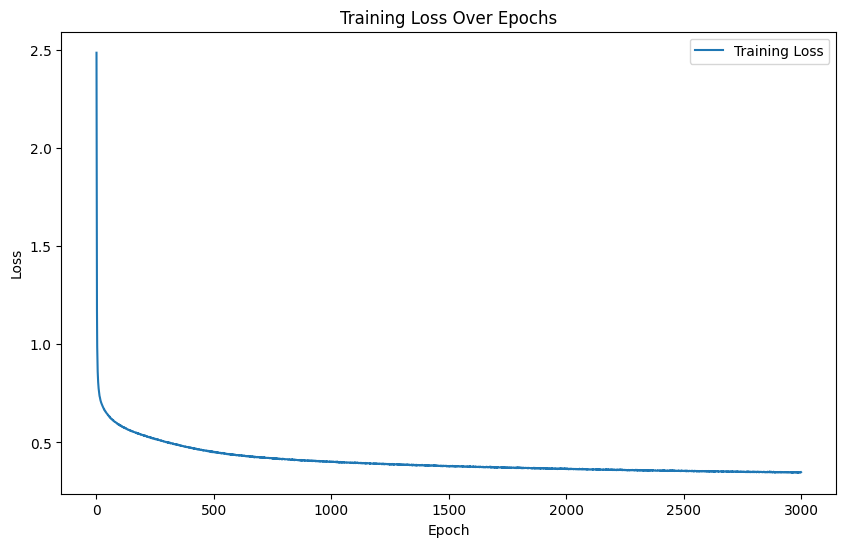

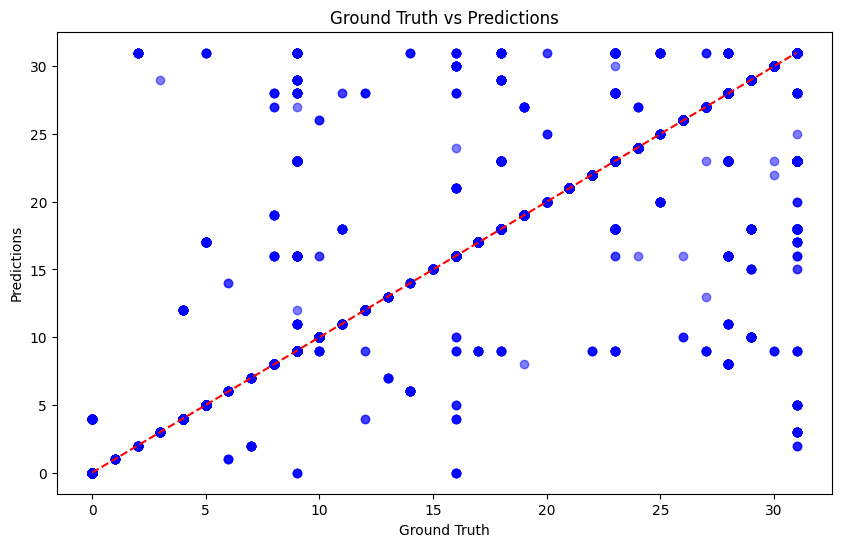

In [ ]:
import torch
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

tensor_data_path = "/content/run1b_2018-05-29-14-02-47.kinect_color.pt"
tensor_data = torch.load(tensor_data_path)  # Shape: (num_frames, num_classes)

if isinstance(tensor_data, list):
    tensor_data = torch.tensor(tensor_data, dtype=torch.float32)

annotations_path = "/content/training_data.csv"
annotations_df = pd.read_csv(annotations_path)

annotations_df = annotations_df.replace('NA', 0)

annotations = annotations_df.iloc[:, -1].values

if np.issubdtype(annotations.dtype, np.number):
    annotations_numeric = annotations
else:
    label_encoder = LabelEncoder()
    annotations_numeric = label_encoder.fit_transform(annotations)

scaler = MinMaxScaler()
tensor_data_scaled = scaler.fit_transform(tensor_data.numpy())  # Normalize tensor data to [0, 1]

tensor_data_scaled = torch.tensor(tensor_data_scaled, dtype=torch.float32)

class TemporalActivityDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

dataset = TemporalActivityDataset(tensor_data_scaled, annotations_numeric)
data_loader = DataLoader(dataset, batch_size=64, shuffle=True)

class TemporalActivityModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(TemporalActivityModel, self).__init__()
        self.lstm = torch.nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)

        if lstm_out.ndimension() == 2:
            lstm_out = lstm_out.unsqueeze(1)

        out = self.fc(lstm_out[:, -1, :])
        return out


input_dim = tensor_data_scaled.shape[1]  # Features per frame
hidden_dim = 64
output_dim = len(np.unique(annotations_numeric))  # Number of classes (activities)
model = TemporalActivityModel(input_dim, hidden_dim, output_dim)

criterion = torch.nn.CrossEntropyLoss()  # CrossEntropyLoss for classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 3000
train_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for inputs, labels in data_loader:

        inputs = inputs.float()
        labels = labels.long()

        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Forward pass

        loss = criterion(outputs, labels)  # Loss calculation
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize parameters

        running_loss += loss.item()


        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

    avg_loss = running_loss / len(data_loader)
    accuracy = (correct_predictions / total_predictions) * 100
    train_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")


model.eval()
predictions = []
ground_truth = []

with torch.no_grad():
    for inputs, labels in data_loader:
        inputs = inputs.float()  # Ensure inputs are in float32
        labels = labels.long()  # Ensure labels are in long integers
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)  # Get the predicted class
        predictions.append(predicted.numpy())
        ground_truth.append(labels.numpy())

predictions = np.concatenate(predictions)
ground_truth = np.concatenate(ground_truth)


accuracy = np.mean(predictions == ground_truth) * 100
print(f"Accuracy: {accuracy:.2f}%")


plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()


plt.figure(figsize=(10, 6))
plt.scatter(ground_truth, predictions, color='blue', alpha=0.5)
plt.plot([min(ground_truth), max(ground_truth)], [min(ground_truth), max(ground_truth)], color='red', linestyle='--')
plt.xlabel('Ground Truth')
plt.ylabel('Predictions')
plt.title('Ground Truth vs Predictions')
plt.show()


<ipython-input-2-1e7deac3af73>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor_data = torch.load(tensor_data_path)  # Shape: (num_frames, num_classes)


Streaming output truncated to the last 5000 lines.
Epoch [2/5000], Loss: 1.6152, Accuracy: 53.87%
Epoch [3/5000], Loss: 1.1470, Accuracy: 65.95%
Epoch [4/5000], Loss: 0.9833, Accuracy: 68.84%
Epoch [5/5000], Loss: 0.9032, Accuracy: 70.44%
Epoch [6/5000], Loss: 0.8556, Accuracy: 70.69%
Epoch [7/5000], Loss: 0.8244, Accuracy: 71.26%
Epoch [8/5000], Loss: 0.8011, Accuracy: 71.49%
Epoch [9/5000], Loss: 0.7846, Accuracy: 71.44%
Epoch [10/5000], Loss: 0.7697, Accuracy: 72.18%
Epoch [11/5000], Loss: 0.7587, Accuracy: 72.40%
Epoch [12/5000], Loss: 0.7491, Accuracy: 72.54%
Epoch [13/5000], Loss: 0.7408, Accuracy: 72.77%
Epoch [14/5000], Loss: 0.7340, Accuracy: 72.89%
Epoch [15/5000], Loss: 0.7275, Accuracy: 73.14%
Epoch [16/5000], Loss: 0.7208, Accuracy: 73.23%
Epoch [17/5000], Loss: 0.7168, Accuracy: 73.07%
Epoch [18/5000], Loss: 0.7096, Accuracy: 73.47%
Epoch [19/5000], Loss: 0.7072, Accuracy: 73.60%
Epoch [20/5000], Loss: 0.7036, Accuracy: 73.65%
Epoch [21/5000], Loss: 0.6977, Accuracy: 74.1

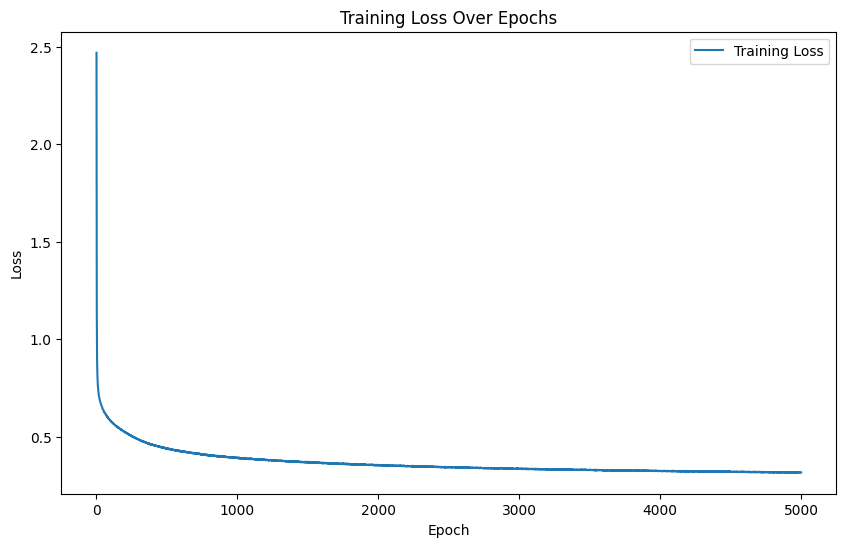

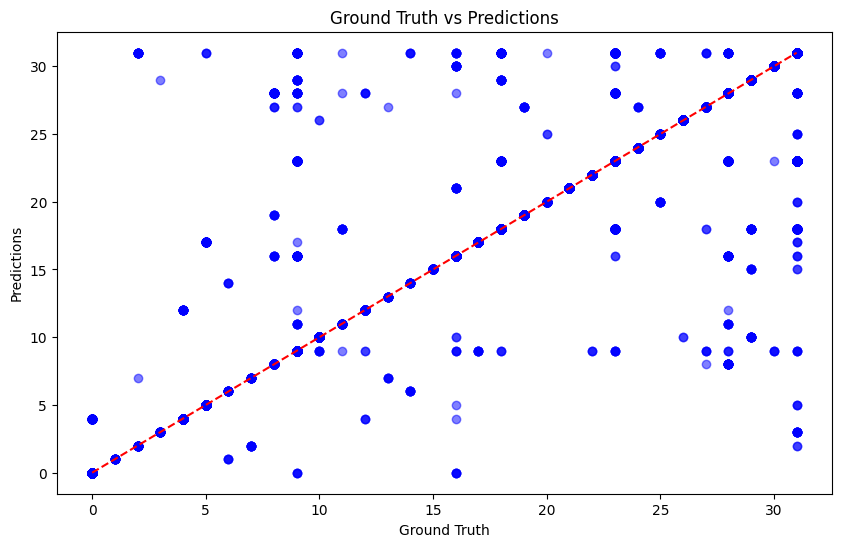

In [ ]:
import torch
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

tensor_data_path = "/content/run1b_2018-05-29-14-02-47.kinect_color.pt"
tensor_data = torch.load(tensor_data_path)  # Shape: (num_frames, num_classes)

if isinstance(tensor_data, list):
    tensor_data = torch.tensor(tensor_data, dtype=torch.float32)

annotations_path = "/content/training_data.csv"
annotations_df = pd.read_csv(annotations_path)

annotations_df = annotations_df.replace('NA', 0)

annotations = annotations_df.iloc[:, -1].values

if np.issubdtype(annotations.dtype, np.number):
    annotations_numeric = annotations
else:
    label_encoder = LabelEncoder()
    annotations_numeric = label_encoder.fit_transform(annotations)

scaler = MinMaxScaler()
tensor_data_scaled = scaler.fit_transform(tensor_data.numpy())  # Normalize tensor data to [0, 1]

tensor_data_scaled = torch.tensor(tensor_data_scaled, dtype=torch.float32)

class TemporalActivityDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

dataset = TemporalActivityDataset(tensor_data_scaled, annotations_numeric)
data_loader = DataLoader(dataset, batch_size=64, shuffle=True)

class TemporalActivityModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(TemporalActivityModel, self).__init__()
        self.lstm = torch.nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)

        if lstm_out.ndimension() == 2:
            lstm_out = lstm_out.unsqueeze(1)

        out = self.fc(lstm_out[:, -1, :])
        return out


input_dim = tensor_data_scaled.shape[1]  # Features per frame
hidden_dim = 64
output_dim = len(np.unique(annotations_numeric))  # Number of classes (activities)
model = TemporalActivityModel(input_dim, hidden_dim, output_dim)

criterion = torch.nn.CrossEntropyLoss()  # CrossEntropyLoss for classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5000
train_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for inputs, labels in data_loader:

        inputs = inputs.float()
        labels = labels.long()

        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Forward pass

        loss = criterion(outputs, labels)  # Loss calculation
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize parameters

        running_loss += loss.item()


        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

    avg_loss = running_loss / len(data_loader)
    accuracy = (correct_predictions / total_predictions) * 100
    train_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")


model.eval()
predictions = []
ground_truth = []

with torch.no_grad():
    for inputs, labels in data_loader:
        inputs = inputs.float()  # Ensure inputs are in float32
        labels = labels.long()  # Ensure labels are in long integers
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)  # Get the predicted class
        predictions.append(predicted.numpy())
        ground_truth.append(labels.numpy())

predictions = np.concatenate(predictions)
ground_truth = np.concatenate(ground_truth)


accuracy = np.mean(predictions == ground_truth) * 100
print(f"Accuracy: {accuracy:.2f}%")


plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()


plt.figure(figsize=(10, 6))
plt.scatter(ground_truth, predictions, color='blue', alpha=0.5)
plt.plot([min(ground_truth), max(ground_truth)], [min(ground_truth), max(ground_truth)], color='red', linestyle='--')
plt.xlabel('Ground Truth')
plt.ylabel('Predictions')
plt.title('Ground Truth vs Predictions')
plt.show()


<ipython-input-1-85299147a821>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor_data = torch.load(tensor_data_path)  # Shape: (num_frames, num_classes)
<ipython-inpu

Streaming output truncated to the last 5000 lines.
Epoch [2002/7000], Loss: 0.3634, Accuracy: 87.40%
Epoch [2003/7000], Loss: 0.3642, Accuracy: 87.50%
Epoch [2004/7000], Loss: 0.3626, Accuracy: 87.47%
Epoch [2005/7000], Loss: 0.3626, Accuracy: 87.48%
Epoch [2006/7000], Loss: 0.3624, Accuracy: 87.48%
Epoch [2007/7000], Loss: 0.3635, Accuracy: 87.40%
Epoch [2008/7000], Loss: 0.3625, Accuracy: 87.56%
Epoch [2009/7000], Loss: 0.3623, Accuracy: 87.64%
Epoch [2010/7000], Loss: 0.3619, Accuracy: 87.40%
Epoch [2011/7000], Loss: 0.3629, Accuracy: 87.39%
Epoch [2012/7000], Loss: 0.3606, Accuracy: 87.54%
Epoch [2013/7000], Loss: 0.3626, Accuracy: 87.39%
Epoch [2014/7000], Loss: 0.3617, Accuracy: 87.46%
Epoch [2015/7000], Loss: 0.3623, Accuracy: 87.53%
Epoch [2016/7000], Loss: 0.3620, Accuracy: 87.44%
Epoch [2017/7000], Loss: 0.3623, Accuracy: 87.62%
Epoch [2018/7000], Loss: 0.3637, Accuracy: 87.42%
Epoch [2019/7000], Loss: 0.3627, Accuracy: 87.55%
Epoch [2020/7000], Loss: 0.3632, Accuracy: 87.43%

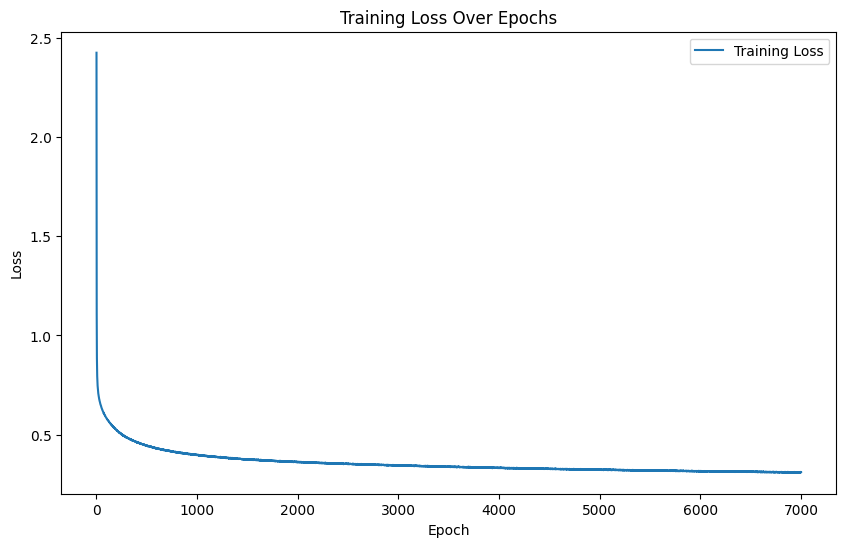

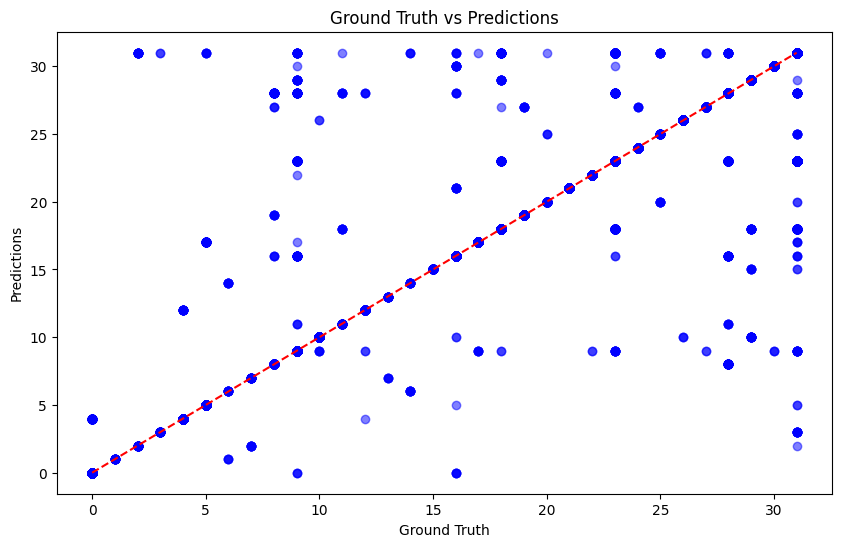

In [ ]:
import torch
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

tensor_data_path = "/content/run1b_2018-05-29-14-02-47.kinect_color.pt"
tensor_data = torch.load(tensor_data_path)  # Shape: (num_frames, num_classes)

if isinstance(tensor_data, list):
    tensor_data = torch.tensor(tensor_data, dtype=torch.float32)

annotations_path = "/content/training_data.csv"
annotations_df = pd.read_csv(annotations_path)

annotations_df = annotations_df.replace('NA', 0)

annotations = annotations_df.iloc[:, -1].values

if np.issubdtype(annotations.dtype, np.number):
    annotations_numeric = annotations
else:
    label_encoder = LabelEncoder()
    annotations_numeric = label_encoder.fit_transform(annotations)

scaler = MinMaxScaler()
tensor_data_scaled = scaler.fit_transform(tensor_data.numpy())  # Normalize tensor data to [0, 1]

tensor_data_scaled = torch.tensor(tensor_data_scaled, dtype=torch.float32)

class TemporalActivityDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

dataset = TemporalActivityDataset(tensor_data_scaled, annotations_numeric)
data_loader = DataLoader(dataset, batch_size=64, shuffle=True)

class TemporalActivityModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(TemporalActivityModel, self).__init__()
        self.lstm = torch.nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)

        if lstm_out.ndimension() == 2:
            lstm_out = lstm_out.unsqueeze(1)

        out = self.fc(lstm_out[:, -1, :])
        return out


input_dim = tensor_data_scaled.shape[1]  # Features per frame
hidden_dim = 64
output_dim = len(np.unique(annotations_numeric))  # Number of classes (activities)
model = TemporalActivityModel(input_dim, hidden_dim, output_dim)

criterion = torch.nn.CrossEntropyLoss()  # CrossEntropyLoss for classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 7000
train_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for inputs, labels in data_loader:

        inputs = inputs.float()
        labels = labels.long()

        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Forward pass

        loss = criterion(outputs, labels)  # Loss calculation
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize parameters

        running_loss += loss.item()


        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

    avg_loss = running_loss / len(data_loader)
    accuracy = (correct_predictions / total_predictions) * 100
    train_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")


model.eval()
predictions = []
ground_truth = []

with torch.no_grad():
    for inputs, labels in data_loader:
        inputs = inputs.float()  # Ensure inputs are in float32
        labels = labels.long()  # Ensure labels are in long integers
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)  # Get the predicted class
        predictions.append(predicted.numpy())
        ground_truth.append(labels.numpy())

predictions = np.concatenate(predictions)
ground_truth = np.concatenate(ground_truth)


accuracy = np.mean(predictions == ground_truth) * 100
print(f"Accuracy: {accuracy:.2f}%")


plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()


plt.figure(figsize=(10, 6))
plt.scatter(ground_truth, predictions, color='blue', alpha=0.5)
plt.plot([min(ground_truth), max(ground_truth)], [min(ground_truth), max(ground_truth)], color='red', linestyle='--')
plt.xlabel('Ground Truth')
plt.ylabel('Predictions')
plt.title('Ground Truth vs Predictions')
plt.show()
